<a href="https://colab.research.google.com/github/fadhilsalih1994/Image-Processing/blob/master/Kangaroo_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget git clone https://github.com/matterport/Mask_RCNN.git


--2019-08-15 21:26:23--  http://git/
Resolving git (git)... failed: Name or service not known.
wget: unable to resolve host address ‘git’
--2019-08-15 21:26:23--  http://clone/
Resolving clone (clone)... failed: Name or service not known.
wget: unable to resolve host address ‘clone’
--2019-08-15 21:26:23--  https://github.com/matterport/Mask_RCNN.git
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/matterport/Mask_RCNN [following]
--2019-08-15 21:26:23--  https://github.com/matterport/Mask_RCNN
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Mask_RCNN.git’

Mask_RCNN.git           [ <=>                ] 126.33K  --.-KB/s    in 0.04s   

2019-08-15 21:26:23 (3.27 MB/s) - ‘Mask_RCNN.git’ saved [129363]

FINISHED --2019-08-15 21:26:23--


In [3]:
!ls

drive  sample_data


In [2]:
pip install mrcnn

     |████████████████████████████████| 61kB 2.5MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54932 sha256=abdff4592c36f0df0e2943df7f073742057d6ed2481615d889c59e2990e3377e
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


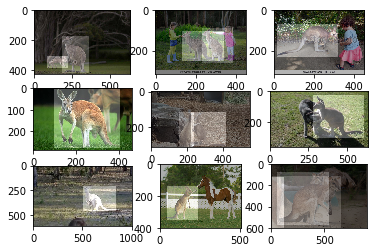

In [3]:
from os import listdir
from numpy import zeros
from numpy import asarray
from xml.etree import ElementTree
from mrcnn.utils import Dataset
from matplotlib import pyplot
# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height
 
	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']
 
# train set
train_set = KangarooDataset()
train_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/kangaroo', is_train=True)
train_set.prepare()

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [4]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
class KangarooConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131
 
# prepare train set
train_set = KangarooDataset()
train_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = KangarooDataset()
test_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = KangarooConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='drive/My Drive/Masters_Research_Project/Mask_RCNN/', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('drive/My Drive/Masters_Research_Project/Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=2, layers='heads')



Train: 131
Test: 32

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [

Using TensorFlow backend.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

Starting at epoch 0. LR=0.001

Checkpoint Path: drive/My Drive/Masters_Research_Project/Mask_RCNN/kangaroo_cfg20190922T1815/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_m

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker



Epoch 1/2
131/131 [==============================] - 14859s 113s/step - loss: 1.2984 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.2116 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.3701 - mrcnn_mask_loss: 0.6722 - val_loss: 1.2421 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.3257 - val_mrcnn_class_loss: 0.0372 - val_mrcnn_bbox_loss: 0.2764 - val_mrcnn_mask_loss: 0.5932
Epoch 2/2
131/131 [==============================] - 14897s 114s/step - loss: 0.9607 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.5836 - val_loss: 1.1332 - val_rpn_class_loss: 0.0067 - val_rpn_bbox_loss: 0.2857 - val_mrcnn_class_loss: 0.0209 - val_mrcnn_bbox_loss: 0.2449 - val_mrcnn_mask_loss: 0.5750




In [6]:
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='drive/My Drive/Masters_Research_Project/Mask_RCNN/', config=cfg)
# load model weights
model.load_weights('drive/My Drive/Masters_Research_Project/Mask_RCNN/kangaroo_cfg20190922T1815/mask_rcnn_kangaroo_cfg_0002.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Re-starting from epoch 2
Train mAP: 0.518
Test mAP: 0.430


Re-starting from epoch 2


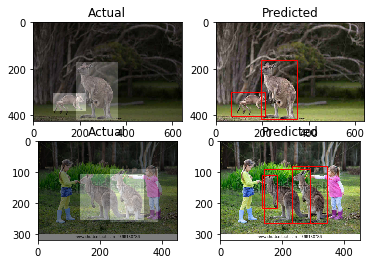

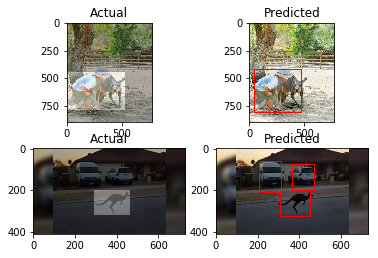

In [8]:
from mrcnn.model import MaskRCNN
from matplotlib.patches import Rectangle
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=2):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()
model = MaskRCNN(mode='inference', model_dir='drive/My Drive/Masters_Research_Project/Mask_RCNN/', config=cfg)
model_path = 'drive/My Drive/Masters_Research_Project/Mask_RCNN/kangaroo_cfg20190922T1815/mask_rcnn_kangaroo_cfg_0002.h5'
model.load_weights(model_path, by_name=True)
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)